In [207]:
import numpy as np
import matplotlib.pyplot as plt
from utils import mnist_reader
from skimage.feature import greycomatrix, greycoprops
from skimage import data
import pandas as pd
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,5)

In [32]:
test_img = np.array([[0,0,1,1],[0,0,1,1],[0,2,2,2],[2,2,3,3]])

In [33]:
test_img

array([[0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 2, 2, 2],
       [2, 2, 3, 3]])

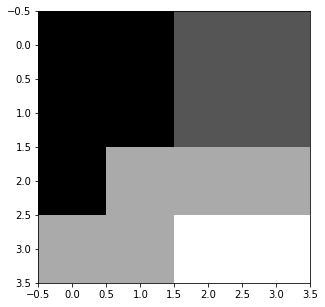

In [34]:
plt.imshow(test_img,cmap='gray')

In [35]:
glcm = greycomatrix(test_img,[1],[np.pi/2],4,symmetric=True,normed=True)

In [36]:
print(glcm.ravel())

[0.25       0.         0.08333333 0.         0.         0.16666667
 0.08333333 0.         0.08333333 0.08333333 0.08333333 0.08333333
 0.         0.         0.08333333 0.        ]


## GLDV

In [37]:
#GLDV (Grey-level difference vector)
def gldv(glcm):
    gldv = np.zeros(len(glcm))
    for i in range(len(glcm)):
        if(i>0):
            gldv[i]=np.trace(glcm, offset=i)*2
        else:
            gldv[i]=np.trace(glcm, offset=i)
            
    return gldv

In [38]:
a = gldv(glcm)

In [39]:
a

array([0.5       , 0.33333333, 0.16666667, 0.        ])

## GLCM  Measures

GLCM proerties from skiimage  
greycoprops(GLCM, prop='measure')  
measure   
‘contrast’: $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$  
‘dissimilarity’: $\sum_{i,j=0}^{levels-1} P_{i,j}|i-j|$  
‘homogeneity’ : $\sum_{i,j=0}^{levels-1} \frac{P_{i,j}}{1+(i-j)^2}$  
‘ASM’$\sum_{i,j=0}^{levels-1} P^2_{i,j}$   
‘energy’ $\sqrt{ASM}$  
‘correlation’  $\sum_{i,j=0}^{levels-1} P_{i,j}\frac{(i-\mu_i)(j-\mu_j)}{\sqrt{\sigma_i^2\sigma_j^2}}$

In [40]:
def glcm_props (glcm):
    contrast = greycoprops(glcm,'contrast')
    dissimilarity = greycoprops(glcm,'dissimilarity')
    homogeneity = greycoprops(glcm,'homogeneity')
    ASM = greycoprops(glcm,'ASM')
    energy = greycoprops(glcm,'energy')
    correlation = greycoprops(glcm,'correlation')
    return np.array([contrast, dissimilarity, homogeneity, ASM, energy, correlation])

## Load Zalando fashion data

In [224]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [225]:
X_dataset = np.concatenate((X_train,X_test))
Y_dataset = np.concatenate((y_train,y_test))

## Make own dataset (smaller)

De todo el conjunto queremos sacar 100 elementos de 4 clases para obtener los descriptores y clasificar.

In [275]:
# Especificamos cuántos elementos de cada clase queremos coger, máximo de 7000 ya que el conjunto de
# Zalando tiene 6000+1000 en train+test para cada clase
elements = 100
# Especificamos qué clases queremos coger entre 0 y 9 incluidos.
labels = np.array([0,1,2,3])

#Creamos nuestro propio dataset reducido
my_X_dataset = np.zeros((elements*len(labels),28*28))
my_Y_dataset = np.zeros(elements*len(labels))
for i in range(len(labels)):
    ind = (Y_dataset==labels[i])
    my_X_dataset[i*elements:elements*(i+1),] = X_dataset[ind][0:elements]
    my_Y_dataset[i*elements:elements*(i+1)] = Y_dataset[ind][0:elements]

my_X_dataset = my_X_dataset.astype(np.uint8)
my_Y_dataset = my_Y_dataset.astype(np.uint8)

In [276]:
# Dividimos nuestro dataset en train y test mediante el uso de train_test_split de scikit-learn
my_X_train, my_X_test, my_y_train, my_y_test = train_test_split(my_X_dataset, my_Y_dataset, test_size=0.2, random_state=42)

In [277]:
# Revisamos la distribución que ha hecho scikit de los datos
u, counts = np.unique(my_y_train, return_counts=True)
print(u)
print(counts)

[0 1 2 3]
[74 82 82 82]


In [283]:
measures = np.zeros([len(my_X_train),6])
#We get all the measures for each image. We calculate the glcm for all the image and get the properties for everyone
glcm_hists = np.zeros([len(my_X_train),256*256])
for i in range(len(measures)):
    image = my_X_train[i].reshape(28,28).copy()
    glcm = greycomatrix(image,distances=[1],angles=[0],levels=256,symmetric=True,normed=True)
    glcm_hists[i,:] = glcm.flatten()
    measures[i,:] = glcm_props(glcm).flatten()
    

In [279]:
measures

array([[1.93776984e+03, 2.12486772e+01, 3.52261540e-01, 8.84519960e-02,
        2.97408803e-01, 8.64858933e-01],
       [2.14828571e+03, 2.34920635e+01, 3.07014148e-01, 4.37094076e-02,
        2.09067950e-01, 8.71125033e-01],
       [3.92081481e+03, 3.39576720e+01, 2.77618977e-01, 4.68649394e-02,
        2.16483116e-01, 8.11981267e-01],
       ...,
       [2.42099206e+03, 2.73148148e+01, 3.49755020e-01, 9.73639456e-02,
        3.12031962e-01, 5.52753821e-01],
       [2.55158466e+03, 2.03280423e+01, 6.22800456e-01, 3.72132289e-01,
        6.10026466e-01, 8.61376626e-01],
       [5.14775132e+03, 3.23227513e+01, 6.26415126e-01, 3.67354812e-01,
        6.06098022e-01, 7.44168287e-01]])

In [27]:
y_labels = ['0:T-shirt/top','1:Trouser','2:Pullover','3:Dress','4:Coat','5:Sandal','6:Shirt','7:Sneaker','8:Bag','9:Ankle boot']

<function matplotlib.pyplot.show(close=None, block=None)>

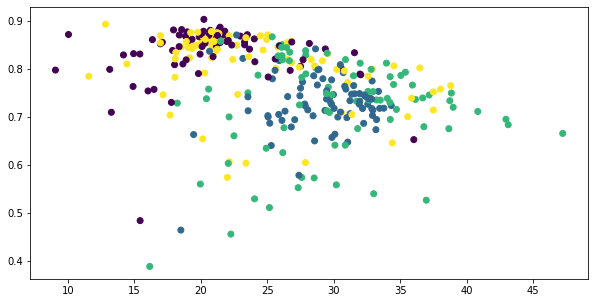

In [281]:
plt.scatter(measures[0:,1],measures[0:,5],c=my_y_train)
plt.show

In [405]:
y_labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']